
=== RF-baseline ===
Accuracy : 0.8299
Precision: 0.8505
Recall   : 0.8054
F1-score : 0.8273
AUROC    : 0.9117

=== XGB-baseline ===
Accuracy : 0.7963
Precision: 0.8147
Recall   : 0.7733
F1-score : 0.7935
AUROC    : 0.8774

=== RF-optimized ===
Accuracy : 0.7990
Precision: 0.8268
Recall   : 0.7626
F1-score : 0.7934
AUROC    : 0.8786

=== XGB-optimized ===
Accuracy : 0.7715
Precision: 0.7877
Recall   : 0.7507
F1-score : 0.7687
AUROC    : 0.8470

=== Stacking (RF+XGB) ===
Accuracy : 0.8294
Precision: 0.8436
Recall   : 0.8137
F1-score : 0.8284
AUROC    : 0.9120

=== Metrics summary table ===
               model  accuracy  precision  recall     f1  auroc
0        RF-baseline     0.830      0.850   0.805  0.827  0.912
1       XGB-baseline     0.796      0.815   0.773  0.793  0.877
2       RF-optimized     0.799      0.827   0.763  0.793  0.879
3      XGB-optimized     0.771      0.788   0.751  0.769  0.847
4  Stacking (RF+XGB)     0.829      0.844   0.814  0.828  0.912


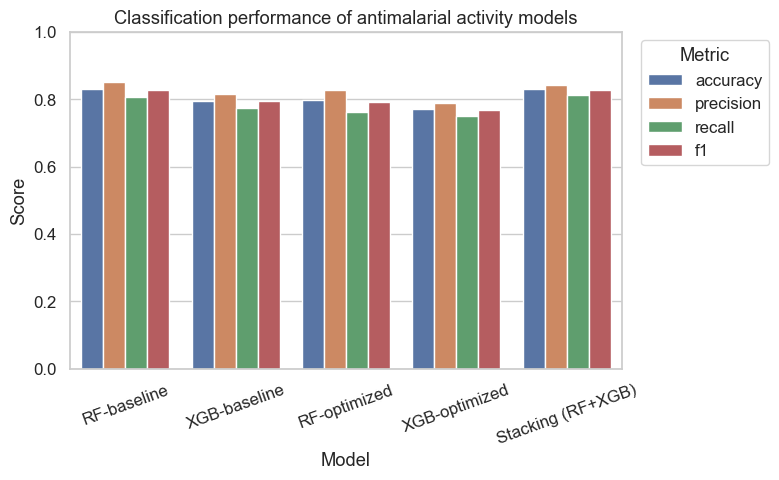

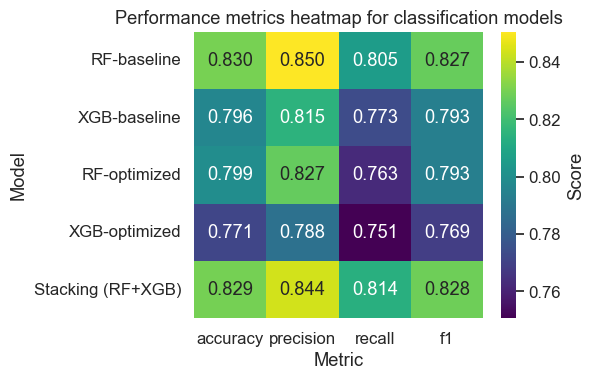

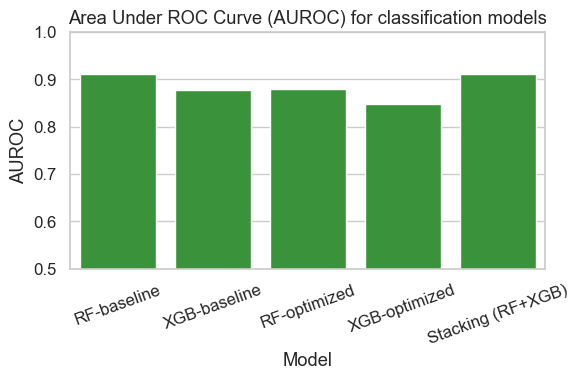

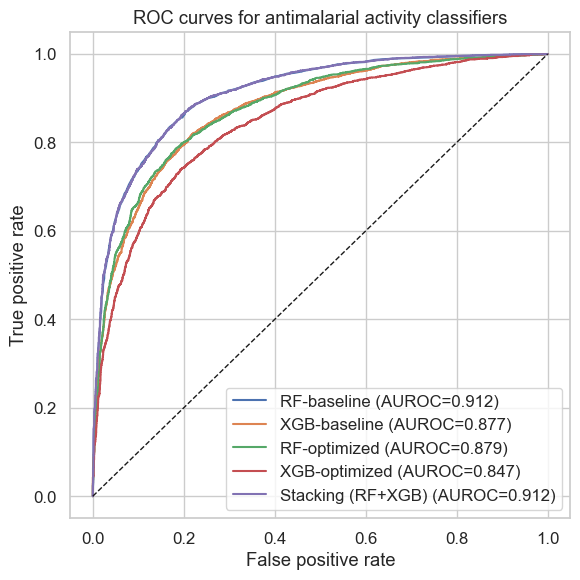

In [2]:
# ============================================
# Full evaluation + tables + plots + AUROC
# ============================================
import numpy as np
import pandas as pd
import joblib
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

# ------------------------------------------------
# 1. Load data and recreate train/test split
# ------------------------------------------------
X = np.load("../data/features_combined.npy")
y = pd.read_csv("../data/labels.csv")
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 3) Apply the SAME scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

# 4) Use the SAME split configuration
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
# ------------------------------------------------
# 2. Helper to evaluate one classifier
# ------------------------------------------------
def evaluate_classifier(model, X_test, y_test, name):
    """
    Compute Accuracy, Precision, Recall, F1, AUROC,
    and return dict + predicted probabilities for ROC curves.
    """
    # class labels
    y_pred = model.predict(X_test)

    # probability for positive class (label 1)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", pos_label=1
    )
    auroc = roc_auc_score(y_test, y_proba)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"AUROC    : {auroc:.4f}")

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auroc": auroc,
        "y_proba": y_proba,
    }

# ------------------------------------------------
# 3. Load models and evaluate
# ------------------------------------------------
results = []

rf = joblib.load("../models/random_forest_model.pkl")
results.append(evaluate_classifier(rf, X_test, y_test, "RF-baseline"))

xgb = joblib.load("../models/xgboost_model.pkl")
results.append(evaluate_classifier(xgb, X_test, y_test, "XGB-baseline"))

rf_opt = joblib.load("../models/random_forest_optimized.pkl")
results.append(evaluate_classifier(rf_opt, X_test, y_test, "RF-optimized"))

xgb_opt = joblib.load("../models/xgboost_optimized.pkl")
results.append(evaluate_classifier(xgb_opt, X_test, y_test, "XGB-optimized"))

stack = joblib.load("../models/stacking_model.pkl")
results.append(evaluate_classifier(stack, X_test, y_test, "Stacking (RF+XGB)"))

# ------------------------------------------------
# 4. Build metrics table
# ------------------------------------------------
metrics_df = pd.DataFrame(
    [
        {
            "model": r["model"],
            "accuracy": r["accuracy"],
            "precision": r["precision"],
            "recall": r["recall"],
            "f1": r["f1"],
            "auroc": r["auroc"],
        }
        for r in results
    ]
)

metrics_df_round = metrics_df.copy()
for col in ["accuracy", "precision", "recall", "f1", "auroc"]:
    metrics_df_round[col] = metrics_df_round[col].round(3)

print("\n=== Metrics summary table ===")
print(metrics_df_round)

metrics_df_round.to_csv(
    "../results/classifier_metrics_all_core_models.csv", index=False
)

# ------------------------------------------------
# 5. Bar plot: all metrics × models
#    (accuracy, precision, recall, F1)
# ------------------------------------------------
melt_df = metrics_df.melt(
    id_vars="model",
    value_vars=["accuracy", "precision", "recall", "f1"],
    var_name="metric",
    value_name="score",
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=melt_df,
    x="model",
    y="score",
    hue="metric",
    palette="deep",
)
ax.set_ylim(0, 1.0)
ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Classification performance of antimalarial activity models")
plt.xticks(rotation=20)
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../images/fig_classifiers_bar_all_metrics.png", dpi=300)
plt.show()

# ------------------------------------------------
# 6. Heatmap of metrics (accuracy, precision, recall, F1)
# ------------------------------------------------
heat_df = metrics_df.set_index("model")[["accuracy", "precision", "recall", "f1"]]

plt.figure(figsize=(6, 4))
sns.heatmap(
    heat_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    cbar_kws={"label": "Score"},
)
plt.title("Performance metrics heatmap for classification models")
plt.xlabel("Metric")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("../images/fig_classifiers_heatmap.png", dpi=300)
plt.show()

# ------------------------------------------------
# 7. AUROC bar plot (one bar per model)
# ------------------------------------------------
plt.figure(figsize=(6, 4))
sns.barplot(
    data=metrics_df,
    x="model",
    y="auroc",
    color="#2ca02c",
)
plt.ylim(0.5, 1.0)  # adjust lower bound if needed
plt.ylabel("AUROC")
plt.xlabel("Model")
plt.title("Area Under ROC Curve (AUROC) for classification models")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("../images/fig_classifiers_auroc_bar.png", dpi=300)
plt.show()

# ------------------------------------------------
# 8. ROC curves for all models on one axis
# ------------------------------------------------
plt.figure(figsize=(6, 6))

for r in results:
    fpr, tpr, _ = roc_curve(y_test, r["y_proba"])
    plt.plot(
        fpr,
        tpr,
        linewidth=1.5,
        label=f"{r['model']} (AUROC={r['auroc']:.3f})",
    )

plt.plot([0, 1], [0, 1], "k--", linewidth=1)  # random baseline
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves for antimalarial activity classifiers")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../images/fig_classifiers_roc_curves.png", dpi=300)
plt.show()


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)

# -------------------------------------------------
# 1. Recreate X and y exactly as during training
# -------------------------------------------------
# Replace with whatever you actually used when training
# Example:
X = np.load("../data/docking_results/X_features.npy")      # shape: (N, d)
y = np.load("../data/docking_results/y_docking_scores.npy")        # shape: (N, 4)

protein_names = ["9NSR", "3EBH", "8EM8", "3I65"]

# -------------------------------------------------
# 2. Same split as training, but then shrink val set
# -------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Choose a safe subset size of the validation set.
# 5,000–20,000 usually works well on a typical laptop.
max_val = min(10000, X_val.shape[0])  # adjust 10000 up/down if needed

# Take a random subset of the validation indices for similar distribution
rng = np.random.default_rng(42)
subset_idx = rng.choice(X_val.shape[0], size=max_val, replace=False)

X_eval = X_val[subset_idx]
y_eval = y_val[subset_idx]

print(f"Evaluating on {X_eval.shape[0]} samples out of {X_val.shape[0]} validation points.")

# -------------------------------------------------
# 3. Load the trained model
# -------------------------------------------------
model = tf.keras.models.load_model(
    "../models/docking_score_prediction_model.h5",
    custom_objects={"mse": tf.keras.metrics.MeanSquaredError()},
)

# Predict in reasonably sized batches to limit memory
y_pred = model.predict(X_eval, batch_size=512)

# -------------------------------------------------
# 4. Compute metrics per protein (MSE, RMSE, R2)
# -------------------------------------------------
rows = []
for i, pname in enumerate(protein_names):
    y_true = y_eval[:, i]
    y_hat = y_pred[:, i]

    mse = mean_squared_error(y_true, y_hat)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true, y_hat)

    rows.append(
        {
            "protein": pname,
            "mse": mse,
            "rmse": rmse,
            "r2": r2,
        }
    )

metrics_df = pd.DataFrame(rows)
metrics_round = metrics_df.round({"mse": 3, "rmse": 3, "r2": 3})

print("\nDocking regression metrics on validation subset:")
print(metrics_round)

metrics_round.to_csv("../results/docking_regression_metrics_subset.csv", index=False)

# -------------------------------------------------
# 5. Bar plot of RMSE and R2 per protein
# -------------------------------------------------
melt_df = metrics_df.melt(
    id_vars="protein",
    value_vars=["rmse", "r2"],
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=melt_df,
    x="protein",
    y="value",
    hue="metric",
    palette="Set2",
)
plt.xlabel("Protein target")
plt.ylabel("Value")
plt.title("Docking score regression on validation subset")
plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../images/fig_docking_rmse_r2_bar_subset.png", dpi=300)
plt.show()

# -------------------------------------------------
# 6. Predicted vs true scatter per protein
# -------------------------------------------------
for i, pname in enumerate(protein_names):
    y_true = y_eval[:, i]
    y_hat = y_pred[:, i]

    plt.figure(figsize=(4, 4))
    plt.scatter(y_true, y_hat, alpha=0.4)
    lo = min(y_true.min(), y_hat.min())
    hi = max(y_true.max(), y_hat.max())
    plt.plot([lo, hi], [lo, hi], "r--", linewidth=1)  # y = x line

    plt.xlabel("True docking score")
    plt.ylabel("Predicted docking score")
    plt.title(f"{pname}: predicted vs true (validation subset)")
    plt.tight_layout()
    plt.savefig(f"../images/fig_docking_scatter_{pname}_subset.png", dpi=300)
    plt.show()


MemoryError: Unable to allocate 3.89 GiB for an array with shape (255173, 2048) and data type int64